# REQUISITOS
Para correr este notebook é necessária a instalação do Python e de um conjunto de bibliotecas. Para facilitar a instalação, recomenda-se a instalação do [Anaconda](https://www.anaconda.com/products/individual) e criação de um ambiente a partir do ficheiro geopreprocess.yml disponibilizado na pasta [Conda and PIP env]. Alternativamente, pode-se instalar as bibliotecas usando o comando pip install -r requirements_geopreprocess.txt na linha de comandos

# DESCRIÇÃO
Este notebook é dedicado à georeferenciação da designação "zonas" - áreas territoriais à microescala (o "bairro", o "lugar", ...) - que suportam a construção de Unidades Territoriais de Base. Os dados provêem do campo de pesquisa "zona" no portal de anúncios imobiliários Casa Sapo (ilustrado na figura abaixo), no qual é fornecida uma lista sem qualquer informação geográfica associada. Recorrendo a um processo de georeferenciação baseado na pesquisa das designações de «zona» na API do Google Maps, é assim possível associar a cada zona um par de coordenadas geográficas (latitude e longitude). 
Através da recolha da rede de estradas para a área de estudo em análise (Municipios de Aveiro e Ílhavo) - a partir da API OpenStreetMaps - é identificado o nó mais próximo do ponto de "zona" georeferenciado no passo anterior, permitindo assim a atribuição da designação de zona a um "nó" (ponto, georeferenciado) da rede (de estradas / vias de públicas).

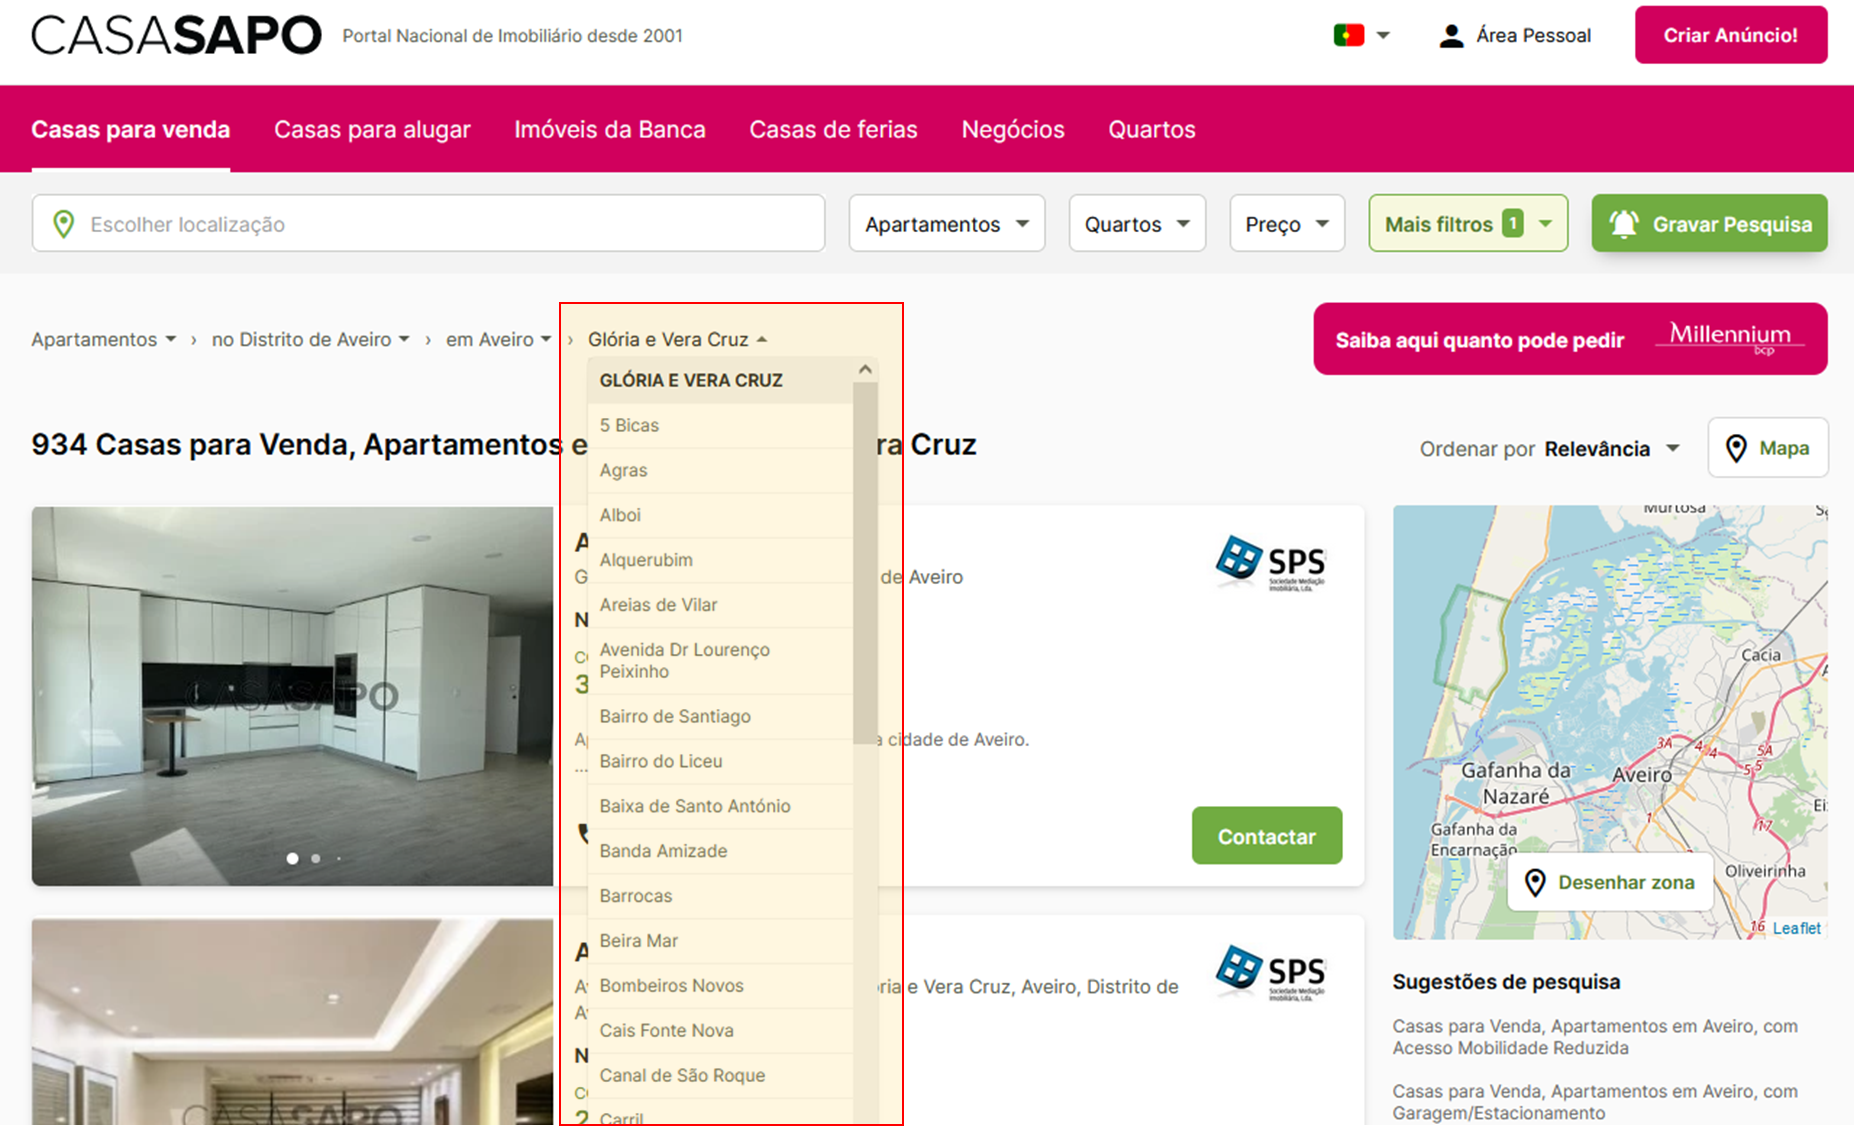


In [4]:
import pandas as pd 
import numpy as np

import geopandas as gpd


import seaborn as sns

# Livrarias para ler dados do openstreetmaps e representação da rede de estradas como um grafo
import osmnx as ox
import networkx as nx

import re

#import pgeocode as pgc
#import geopy

import time

import matplotlib.pyplot as plt

import os

import pickle 






In [5]:
from tqdm import tqdm
#{progress in percentage} | {bar} | {processed}/{total} [{elapsed time}<{remaining time}, {number of iterations per seconds} it/s]

# NOTAS

Notas sobre sistemas de georeferenciação usados neste notebook:

Sistema de georeferenciação projetado, português: ETRS89 / Portugal TM06 - EPSG:3763
Sistema de georeferenciação esfério, internacional (usado no Google Maps e Open Street Maps): WGS 84 - EPSG:4326


# GEOCODING CASA SAPO ZONES

In [8]:
# Open pikle file

open_file = open('../Data/Inputs/db_zones_CasaSapo_ori.piclo', "rb")
zones_CSRA = pickle.load(open_file)
open_file.close()

In [ ]:
colnames = ['Zone_ID', 'Zone_ID_Name', 'Neighborhood_ID_1', 'Neighborhood_GPSLat', 'Neighborhood_GPSLon',
        'Neighborhood_ID_2', 'Neighborhood_Name', 'Town_ID_1', 'Town_GPSLat', 'Town_GPSLon', 'FREG11COD',
        'Town_ID_2', 'Town_Name', 'State_ID', 'Country_ID', 'Town_GPSLon', 'Town_GPSLat', 'MUNICOD11']
zones_CSRA.columns = colnames

In [ ]:
zones_CSRA.head()

In [ ]:
zones_CSRA["geocod_query"] = zones_CSRA["Zone_ID_Name"].astype(str) + ", " + zones_CSRA["Neighborhood_Name"].astype(str)  + ", " +  zones_CSRA["Town_Name"].astype(str) + ", Portugal"
zones_CSRA["geocod_query"].head()

In [19]:
# USE THIS CODE ONLY IF YOU HAVE A GOOGLE API KEY AND WANT TO REPEAT THE GEOREFERENCING PROCESS
# YOU CAN USE THE FILE 'db_zones_CasaSapo_geocoded.piclo' TO CONTINUE THE PROCESSING IN THE FOLLOWING CELLS

from geopy.geocoders import GoogleV3
gkey = 'INSERT YOUR KEY HERE'
geolocator = GoogleV3(api_key=gkey)

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
zones_CSRA['location'] = zones_CSRA['geocod_query'].apply(geocode)


In [9]:
# USE THIS CODE ONLY TO OPEN PREVIOUS SAVED DATA

open_file = open('../Data/Intermediates/db_zones_CasaSapo_geocod_GoogleAPI.pkl', "rb")
zones_CSRA = pickle.load(open_file)
open_file.close()


In [10]:
zones_CSRA.head()

Zone_ID   Zone_ID_Name  Neighborhood_ID_1  Neighborhood_GPSLat  \
0    10331        Quintãs                 64                  0.0   
1    10332     Verdemilho                 64                  0.0   
2    10333  Quinta Picado                 64                  0.0   
3    10334      Eucalipto                 64                  0.0   
4    10335     Bonsucesso                 64                  0.0   

   Neighborhood_GPSLon  Neighborhood_ID_2 Neighborhood_Name  Town_ID_1  \
0                  0.0                 64            Aradas          5   
1                  0.0                 64            Aradas          5   
2                  0.0                 64            Aradas          5   
3                  0.0                 64            Aradas          5   
4                  0.0                 64            Aradas          5   

   Town_GPSLat  Town_GPSLon  ... Town_ID_2  Town_Name State_ID  Country_ID  \
0    40.619312    -8.644814  ...         5     Aveiro        1         620   
1    40.619312    -8.644814  ...         5     Aveiro        1         620   
2    40.619312    -8.644814  ...         5     Aveiro        1         620   
3    40.619312    -8.644814  ...         5     Aveiro        1         620   
4    40.619312    -8.644814  ...         5     Aveiro        1         620   

   Town_GPSLon  Town_GPSLat  MUNICOD11  \
0     -8.65452     40.64114       0105   
1     -8.65452     40.64114       0105   
2     -8.65452     40.64114       0105   
3     -8.65452     40.64114       0105   
4     -8.65452     40.64114       0105   

                              geocod_query  \
0        Quintãs, Aradas, Aveiro, Portugal   
1     Verdemilho, Aradas, Aveiro, Portugal   
2  Quinta Picado, Aradas, Aveiro, Portugal   
3      Eucalipto, Aradas, Aveiro, Portugal   
4     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point  
0          (40.6178803, -8.6373049)  
1  (40.6182926, -8.655233299999999)  
2           (40.5949896, -8.623591)  
3           (40.6258579, -8.647483)  
4          (40.6081347, -8.6461487)  

[5 rows x 21 columns]

In [22]:
zones_CSRA = zones_CSRA[['Zone_ID', 'Zone_ID_Name', "geocod_query", "location", "point"]]

In [23]:
from shapely.geometry import Point
zones_CSRA['point'] = zones_CSRA['location'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None)
zones_CSRA[['Lat','Lon']] = pd.DataFrame(zones_CSRA['point'].tolist(),index=zones_CSRA.index)
zones_CSRA.head()


Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  
0          (40.6178803, -8.6373049)  40.617880 -8.637305  
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233  
2           (40.5949896, -8.623591)  40.594990 -8.623591  
3           (40.6258579, -8.647483)  40.625858 -8.647483  
4          (40.6081347, -8.6461487)  40.608135 -8.646149

In [24]:
zones_CSRA.Zone_ID_Name

0                   Quintãs
1                Verdemilho
2             Quinta Picado
3                 Eucalipto
4                Bonsucesso
               ...         
174                 Sernada
175         Quinta do Torto
176                  Azenha
177                   Presa
178    Gafanha da Boa Vista
Name: Zone_ID_Name, Length: 179, dtype: object

In [25]:
zones_CSRA_gdf = gpd.GeoDataFrame(
    zones_CSRA, geometry=gpd.points_from_xy(zones_CSRA.Lon, zones_CSRA.Lat))

<class 'geopandas.geodataframe.GeoDataFrame'>


<AxesSubplot: >

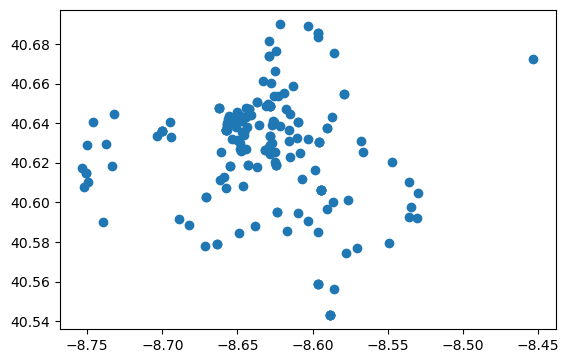

In [26]:

zones_CSRA_gdf_wgs84 = zones_CSRA_gdf.set_crs(epsg=4326, inplace=True)
print(type(zones_CSRA_gdf_wgs84))
zones_CSRA_gdf_wgs84.plot()

# AVRILH Case Study

In [14]:
# OPEN STATISTICAL - CENSUS TRACTS - DATA FOR CASE STUDY
 
open_file = open('../Data/Inputs/db_INE_BGRI11_AVRILH.pkl', "rb")
BGRI11_AVRILH = pickle.load(open_file)
open_file.close()


<AxesSubplot: >

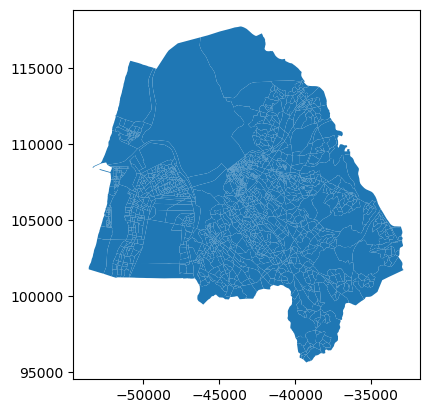

In [15]:
BGRI11_AVRILH[:3]
BGRI11_AVRILH.plot()

In [16]:
BGRI11_AVRILH.crs

<Derived Projected CRS: PROJCS["ETRS_1989_TM06-Portugal",GEOGCS["ETRS89",D ...>
Name: ETRS_1989_TM06-Portugal
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
shape_AVRILH = BGRI11_AVRILH.dissolve(by="CS", as_index=False)
shape_AVRILH = shape_AVRILH.loc[:, ['CS','geometry']]
shape_AVRILH

CS                                           geometry
0  cs  POLYGON ((-51761.956 101187.499, -52088.565 10...

In [18]:
shape_AVRILH_wgs84 = shape_AVRILH.to_crs(epsg=4326)
shape_AVRILH_wgs84

CS                                           geometry
0  cs  POLYGON ((-8.74445 40.57794, -8.74831 40.57880...

<AxesSubplot: >

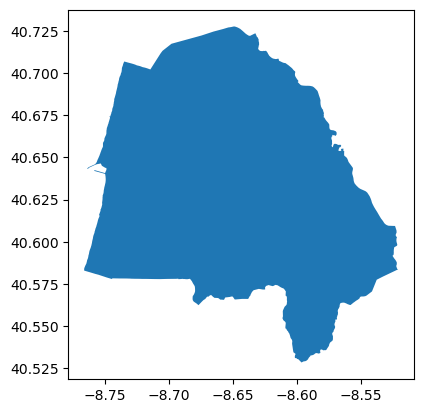

In [19]:
shape_AVRILH_wgs84.plot()

# ZONES vs AVRILH

In [681]:
zones_CSRA_gdf = zones_CSRA_gdf_wgs84.to_crs( epsg=3763 )


<AxesSubplot: >

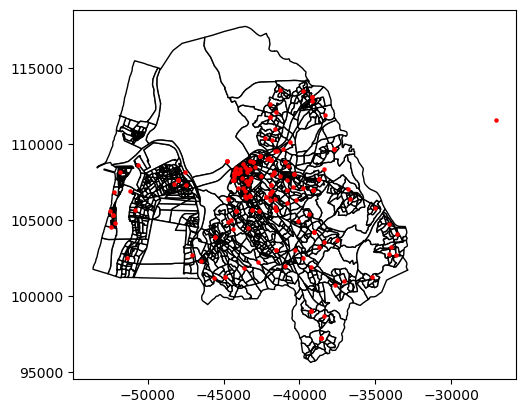

In [682]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

BGRI11_AVRILH.plot(ax=ax, color='white', edgecolor='black')
zones_CSRA_gdf.plot(ax=ax, marker='o', color='red', markersize=5)


In [683]:
zones_CSRA_gdf.shape

(179, 8)

## FIRST CLEAN GEOREFERENCED ZONES

In [685]:
zones_CSRA_toRemove = zones_CSRA_gdf.loc[zones_CSRA_gdf["location"].astype(str).str.match('Aveiro, Portugal') | zones_CSRA_gdf["location"].astype(str).str.match('Ílhavo, Portugal') , "Zone_ID"]
zones_CSRA_toRemove

8      10339
29     10360
74     18483
77     18486
138    18659
142    18663
150    18671
Name: Zone_ID, dtype: int64

In [686]:
zones_CSRA_gdf = zones_CSRA_gdf.loc[~( (zones_CSRA_gdf["location"].astype(str).str.match('Aveiro, Portugal') ) | (zones_CSRA_gdf["location"].astype(str).str.match('Ílhavo, Portugal') ) ) ]
print(zones_CSRA_gdf.shape)
zones_CSRA_gdf.head(3)

(172, 8)


Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   

                        geometry  
0  POINT (-42664.800 105565.754)  
1  POINT (-44181.625 105620.385)  
2  POINT (-41518.497 103017.254)

In [687]:
zones_CSRA_gdf.head(1)

Zone_ID Zone_ID_Name                       geocod_query  \
0    10331      Quintãs  Quintãs, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   

                      point       Lat       Lon                       geometry  
0  (40.6178803, -8.6373049)  40.61788 -8.637305  POINT (-42664.800 105565.754)

# COMBINE AVRILH NETWORK with CASA SAPO LABELS

## AVRILH OSM network

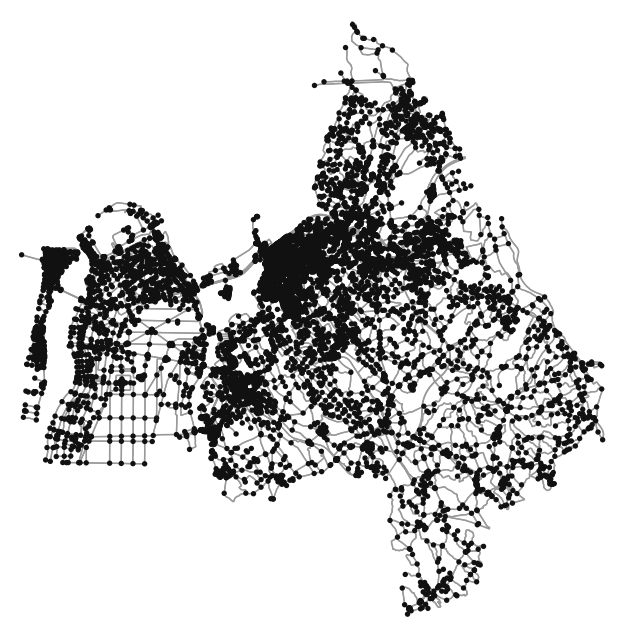

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [688]:
avrilh_network_wgs84 = ox.graph_from_polygon(shape_AVRILH_wgs84['geometry'].iloc[0], network_type='all')
ox.plot_graph(avrilh_network_wgs84, bgcolor='#ffffff', node_color='#111111')

# Note: is simplified https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph_from_polygon#osmnx.graph.graph_from_polygon


In [689]:
avrilh_network_proj = ox.project_graph(avrilh_network_wgs84)


In [690]:
type(avrilh_network_proj)

networkx.classes.multidigraph.MultiDiGraph

In [691]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(avrilh_network_wgs84)

In [692]:
gdf_edges.columns

Index(['osmid', 'oneway', 'lanes', 'highway', 'reversed', 'length', 'geometry',
       'ref', 'name', 'maxspeed', 'bridge', 'junction', 'tunnel', 'service',
       'width', 'access'],
      dtype='object')

In [693]:
gdf_nodes.columns

Index(['y', 'x', 'ref', 'highway', 'street_count', 'geometry'], dtype='object')

In [694]:
avrilh_network_proj.nodes(data=True)

NodeDataView({26018652: {'y': 4491490.1653708955, 'x': 537148.7400832699, 'ref': '15', 'highway': 'motorway_junction', 'street_count': 3, 'lon': -8.5611055, 'lat': 40.573359}, 503706150: {'y': 4491186.373512078, 'x': 537000.2076604628, 'street_count': 3, 'lon': -8.5628781, 'lat': 40.5706289}, 26018669: {'y': 4490834.916635287, 'x': 537188.726399063, 'street_count': 3, 'lon': -8.5606717, 'lat': 40.5674543}, 26018671: {'y': 4490942.389121972, 'x': 537219.4771711489, 'ref': '15', 'highway': 'motorway_junction', 'street_count': 3, 'lon': -8.5603021, 'lat': 40.5684211}, 1713444500: {'y': 4491291.56432817, 'x': 537206.0447208923, 'street_count': 3, 'lon': -8.5604402, 'lat': 40.5715673}, 26019628: {'y': 4497413.435103588, 'x': 522796.8063175373, 'ref': '1', 'highway': 'motorway_junction', 'street_count': 3, 'lon': -8.7304501, 'lat': 40.6272401}, 1893855477: {'y': 4497535.516702635, 'x': 522760.5141424841, 'street_count': 3, 'lon': -8.7308748, 'lat': 40.6283409}, 1650269341: {'y': 4497502.2396

In [695]:

zones_CSRA_gdf.columns

Index(['Zone_ID', 'Zone_ID_Name', 'geocod_query', 'location', 'point', 'Lat',
       'Lon', 'geometry'],
      dtype='object')

In [696]:
zones_CSRA_gdf.loc[1, ['point']].values

array([(40.6182926, -8.655233299999999)], dtype=object)

In [697]:
zones_CSRA_gdf["Lat_ETRS89"] = zones_CSRA_gdf['geometry'].y
zones_CSRA_gdf["Lon_ETRS89"] = zones_CSRA_gdf['geometry'].x

In [698]:
#zones_CSRA_gdf['ID'] = zones_CSRA_gdf.index

In [699]:
zones_CSRA_gdf.head(1)

Zone_ID Zone_ID_Name                       geocod_query  \
0    10331      Quintãs  Quintãs, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   

                      point       Lat       Lon  \
0  (40.6178803, -8.6373049)  40.61788 -8.637305   

                        geometry     Lat_ETRS89   Lon_ETRS89  
0  POINT (-42664.800 105565.754)  105565.753866 -42664.79975

In [700]:
# zones_CSRA_gdf.loc[[2,3],"NewZone_ID"] = 1

## Find nearest node to each original casa sapo zone

In [701]:
zones_close_nodes = ox.distance.nearest_nodes(avrilh_network_wgs84, zones_CSRA_gdf["Lon"], zones_CSRA_gdf["Lat"])
print(zones_close_nodes)
print(len(zones_close_nodes))

[1492490211, 4736412822, 1643344547, 5403604496, 1595015447, 503706174, 1468751927, 1469241555, 1705788746, 1672162106, 1710254977, 1446340007, 1499454679, 4447424154, 403626877, 1384272588, 428671594, 1672162106, 1452642203, 1446340007, 403627339, 1722871025, 1389972386, 1406433840, 689479626, 391649014, 5237682347, 1699771670, 5237682363, 1385017207, 4966381641, 1489672387, 4966381641, 5212764598, 5237764412, 1499454679, 3597445650, 5405381397, 1712973339, 1621822559, 1643344547, 1712958585, 1712958585, 1446340007, 1406433888, 428671594, 4736412822, 1621787810, 1406433840, 2454376715, 2810696856, 5238144381, 6234314597, 1489685311, 1722871025, 1931196527, 1526146469, 1650574179, 3638068933, 5145328396, 5145328396, 3618589041, 1445867533, 3031049567, 1526054224, 3599610777, 9695134127, 9695134127, 1650474591, 3597445654, 6436344425, 1701757828, 1714381883, 1870218475, 1710143711, 1468363371, 1452642203, 2443142043, 1618864168, 1621798874, 5316467160, 3597454297, 1870197808, 1780408503

### !!REPEATED NODES!! VERIFY

In [702]:
res = [idx for idx, val in enumerate(zones_close_nodes) if val in zones_close_nodes[:idx]]
len(res)

40

In [703]:
zones_CSRA_gdf.shape

(172, 10)

In [704]:
zones_close_nodes[1]

4736412822

In [705]:
zones_CSRA_gdf["CLOSE_NODE"] = zones_close_nodes

In [706]:
len(zones_CSRA_gdf["CLOSE_NODE"])

172

In [707]:
zones_CSRA_gdf.head()

Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   
3           (40.6258579, -8.647483)  40.625858 -8.647483   
4          (40.6081347, -8.6461487)  40.608135 -8.646149   

                        geometry     Lat_ETRS89    Lon_ETRS89  CLOSE_NODE  
0  POINT (-42664.800 105565.754)  105565.753866 -42664.799750  1492490211  
1  POINT (-44181.625 105620.385)  105620.384588 -44181.624555  4736412822  
2  POINT (-41518.497 103017.254)  103017.253834 -41518.496927  1643344547  
3  POINT (-43520.890 106456.629)  106456.628774 -43520.889655  5403604496  
4  POINT (-43419.468 104487.858)  104487.857950 -43419.467816  1595015447

In [708]:
# tip: https://stackoverflow.com/questions/65190544/pandas-grouping-by-multiple-categories-for-duplicates
df = pd.pivot_table(zones_CSRA_gdf.assign(count = 1), index = ['CLOSE_NODE'], columns='Zone_ID', values='count', aggfunc = 'count')
df.head()


Zone_ID     10331  10332  10333  10334  10335  10336  10337  10338  10340  \
CLOSE_NODE                                                                  
391649014     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
402741790     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
403626877     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
403627339     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
404737855     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Zone_ID     10341  ...  20828  20829  20830  20831  20832  20833  20834  \
CLOSE_NODE         ...                                                    
391649014     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
402741790     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
403626877     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
403627339     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
404737855     NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Zone_ID     20835  20836  20837  
CLOSE_NODE                       
391649014     NaN    NaN    NaN  
402741790     NaN    NaN    NaN  
403626877     NaN    NaN    NaN  
403627339     NaN    NaN    NaN  
404737855     NaN    NaN    NaN  

[5 rows x 172 columns]

In [709]:
df["jointly_zones"] = df.apply(lambda x: ( [df.columns[i] for i in [index for index,value in enumerate(x) if value == 1] ] ) , axis=1)
df["jointly_zones"] 


CLOSE_NODE
391649014            [10357]
402741790            [18660]
403626877            [10346]
403627339            [10352]
404737855            [18655]
                   ...      
6436344425           [18481]
7280598818           [20833]
7624133996           [18664]
8946987728           [18498]
9695134127    [11646, 11647]
Name: jointly_zones, Length: 132, dtype: object

In [710]:
aux1 = df["jointly_zones"] .apply(pd.Series)
aux1


0        1   2   3   4
CLOSE_NODE                              
391649014   10357.0      NaN NaN NaN NaN
402741790   18660.0      NaN NaN NaN NaN
403626877   10346.0      NaN NaN NaN NaN
403627339   10352.0      NaN NaN NaN NaN
404737855   18655.0      NaN NaN NaN NaN
...             ...      ...  ..  ..  ..
6436344425  18481.0      NaN NaN NaN NaN
7280598818  20833.0      NaN NaN NaN NaN
7624133996  18664.0      NaN NaN NaN NaN
8946987728  18498.0      NaN NaN NaN NaN
9695134127  11646.0  11647.0 NaN NaN NaN

[132 rows x 5 columns]

In [711]:
zones_CSRA_gdf = pd.merge(zones_CSRA_gdf, aux1, left_on='CLOSE_NODE', right_index=True, how='left')
zones_CSRA_gdf.head()

Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   
3           (40.6258579, -8.647483)  40.625858 -8.647483   
4          (40.6081347, -8.6461487)  40.608135 -8.646149   

                        geometry     Lat_ETRS89    Lon_ETRS89  CLOSE_NODE  \
0  POINT (-42664.800 105565.754)  105565.753866 -42664.799750  1492490211   
1  POINT (-44181.625 105620.385)  105620.384588 -44181.624555  4736412822   
2  POINT (-41518.497 103017.254)  103017.253834 -41518.496927  1643344547   
3  POINT (-43520.890 106456.629)  106456.628774 -43520.889655  5403604496   
4  POINT (-43419.468 104487.858)  104487.857950 -43419.467816  1595015447   

         0        1   2   3   4  
0  10331.0      NaN NaN NaN NaN  
1  10332.0  10379.0 NaN NaN NaN  
2  10333.0  10373.0 NaN NaN NaN  
3  10334.0      NaN NaN NaN NaN  
4  10335.0      NaN NaN NaN NaN

In [712]:
zones_CSRA_gdf = pd.merge(zones_CSRA_gdf, df["jointly_zones"], left_on='CLOSE_NODE', right_index=True, how='left')
zones_CSRA_gdf.head()

Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   
3           (40.6258579, -8.647483)  40.625858 -8.647483   
4          (40.6081347, -8.6461487)  40.608135 -8.646149   

                        geometry     Lat_ETRS89    Lon_ETRS89  CLOSE_NODE  \
0  POINT (-42664.800 105565.754)  105565.753866 -42664.799750  1492490211   
1  POINT (-44181.625 105620.385)  105620.384588 -44181.624555  4736412822   
2  POINT (-41518.497 103017.254)  103017.253834 -41518.496927  1643344547   
3  POINT (-43520.890 106456.629)  106456.628774 -43520.889655  5403604496   
4  POINT (-43419.468 104487.858)  104487.857950 -43419.467816  1595015447   

         0        1   2   3   4   jointly_zones  
0  10331.0      NaN NaN NaN NaN         [10331]  
1  10332.0  10379.0 NaN NaN NaN  [10332, 10379]  
2  10333.0  10373.0 NaN NaN NaN  [10333, 10373]  
3  10334.0      NaN NaN NaN NaN         [10334]  
4  10335.0      NaN NaN NaN NaN         [10335]

In [713]:
zones_CSRA_gdf["ZONE_CS_newID_132Z"] = ['_'.join(map(str, l)) for l in zones_CSRA_gdf['jointly_zones']]

zones_CSRA_gdf.head()

Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   
3           (40.6258579, -8.647483)  40.625858 -8.647483   
4          (40.6081347, -8.6461487)  40.608135 -8.646149   

                        geometry     Lat_ETRS89    Lon_ETRS89  CLOSE_NODE  \
0  POINT (-42664.800 105565.754)  105565.753866 -42664.799750  1492490211   
1  POINT (-44181.625 105620.385)  105620.384588 -44181.624555  4736412822   
2  POINT (-41518.497 103017.254)  103017.253834 -41518.496927  1643344547   
3  POINT (-43520.890 106456.629)  106456.628774 -43520.889655  5403604496   
4  POINT (-43419.468 104487.858)  104487.857950 -43419.467816  1595015447   

         0        1   2   3   4   jointly_zones ZONE_CS_newID_132Z  
0  10331.0      NaN NaN NaN NaN         [10331]              10331  
1  10332.0  10379.0 NaN NaN NaN  [10332, 10379]        10332_10379  
2  10333.0  10373.0 NaN NaN NaN  [10333, 10373]        10333_10373  
3  10334.0      NaN NaN NaN NaN         [10334]              10334  
4  10335.0      NaN NaN NaN NaN         [10335]              10335

In [716]:
zones_CSRA_gdf.shape

(172, 18)

In [717]:
### NEW CODE ZONE » ?
zones_CSRA_gdf["ZONE_CS_newID_132Z_CAT"]  = zones_CSRA_gdf[["ZONE_CS_newID_132Z"]].astype('category')
zones_CSRA_gdf["ZONE_CS_newID_132Z_CAT"]  = zones_CSRA_gdf[["ZONE_CS_newID_132Z_CAT"]].apply(lambda x: x.cat.codes)
zones_CSRA_gdf.head()

Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   
3           (40.6258579, -8.647483)  40.625858 -8.647483   
4          (40.6081347, -8.6461487)  40.608135 -8.646149   

                        geometry     Lat_ETRS89    Lon_ETRS89  CLOSE_NODE  \
0  POINT (-42664.800 105565.754)  105565.753866 -42664.799750  1492490211   
1  POINT (-44181.625 105620.385)  105620.384588 -44181.624555  4736412822   
2  POINT (-41518.497 103017.254)  103017.253834 -41518.496927  1643344547   
3  POINT (-43520.890 106456.629)  106456.628774 -43520.889655  5403604496   
4  POINT (-43419.468 104487.858)  104487.857950 -43419.467816  1595015447   

         0        1   2   3   4   jointly_zones ZONE_CS_newID_132Z  \
0  10331.0      NaN NaN NaN NaN         [10331]              10331   
1  10332.0  10379.0 NaN NaN NaN  [10332, 10379]        10332_10379   
2  10333.0  10373.0 NaN NaN NaN  [10333, 10373]        10333_10373   
3  10334.0      NaN NaN NaN NaN         [10334]              10334   
4  10335.0      NaN NaN NaN NaN         [10335]              10335   

   ZONE_CS_newID_132Z_CAT  
0                       0  
1                       1  
2                       2  
3                       3  
4                       4

## SAVE pre-processed zones (after repeated zones in the same nodes)

In [719]:
open_file = open('../Data/Intermediates/db_zones_CasaSapo_133Zones.pkl', "wb")
pickle.dump(zones_CSRA_gdf, open_file)
open_file.close()

## Create node atribute "NODE_ZONE_CS"

In [720]:
nx.set_node_attributes(avrilh_network_wgs84, values = -1, name='NODE_ZONE_CS')

In [721]:
avrilh_network_wgs84.nodes(data=True)[4736412822]["NODE_ZONE_CS"]

-1

In [ ]:
avrilh_network_wgs84.nodes(data=True)

NodeDataView({26018652: {'y': 40.573359, 'x': -8.5611055, 'ref': '15', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26018669: {'y': 40.5674543, 'x': -8.5606717, 'street_count': 3, 'NODE_ZONE_CS': -1}, 26018671: {'y': 40.5684211, 'x': -8.5603021, 'ref': '15', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019628: {'y': 40.6272401, 'x': -8.7304501, 'ref': '1', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019631: {'y': 40.6258744, 'x': -8.7262272, 'ref': '1A', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019636: {'y': 40.6260384, 'x': -8.7191495, 'ref': '1A', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019651: {'y': 40.6311361, 'x': -8.6909085, 'ref': '2', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019652: {'y': 40.6312372, 'x': -8.6909644, 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019653: {'y': 40.631709, 'x': -8.6875

In [722]:
print(zones_close_nodes[1])
print(len(zones_close_nodes))

4736412822
172


In [723]:
avrilh_network_wgs84.nodes().items()

ItemsView(NodeView((26018652, 26018669, 26018671, 26019628, 26019631, 26019636, 26019651, 26019652, 26019653, 26019991, 26019992, 26020326, 26020331, 26020363, 26020371, 26020372, 26020474, 132885841, 132887998, 132888057, 267983421, 267983422, 267983429, 267983444, 330341298, 330341301, 330341302, 330341303, 330341306, 330341308, 330341311, 330341455, 330341607, 336969591, 336969608, 336969639, 336969645, 336969728, 336969772, 336969817, 336969863, 336969872, 336969881, 336969938, 336969964, 336969969, 336970030, 336970038, 336970045, 336970049, 336970052, 336970058, 336970066, 339535423, 339535442, 339535448, 339535463, 349946481, 352646772, 352646776, 356802770, 356802781, 356802791, 356802820, 356803009, 356803033, 356803111, 356803177, 356803188, 383981554, 383981556, 383981895, 383981902, 383982442, 384987357, 384987364, 384987410, 384987412, 384994721, 385008858, 385009960, 385009961, 385009966, 385009968, 385009969, 385010072, 385010593, 385011812, 385013522, 385013604, 3850137

In [724]:
node_info_dict = dict( (n,d) for n,d in avrilh_network_wgs84.nodes().items() )

# list(node_info_dict.keys())

In [740]:
zones_CSRA_gdf.shape

(172, 19)

## ADD original NODE_ZONE_CS to AVRILH_ORI_FULLNETWORK

In [725]:
zones_CSRA_gdf.head()

Zone_ID   Zone_ID_Name                             geocod_query  \
0    10331        Quintãs        Quintãs, Aradas, Aveiro, Portugal   
1    10332     Verdemilho     Verdemilho, Aradas, Aveiro, Portugal   
2    10333  Quinta Picado  Quinta Picado, Aradas, Aveiro, Portugal   
3    10334      Eucalipto      Eucalipto, Aradas, Aveiro, Portugal   
4    10335     Bonsucesso     Bonsucesso, Aradas, Aveiro, Portugal   

                                            location  \
0  (Viela da Quinta, 3810-164, Portugal, (40.6178...   
1  (Verdemilho, 3810-384 Aveiro, Portugal, (40.61...   
2  (Q.ta do Picado, 3810-474 Aveiro, Portugal, (4...   
3  (Travessa do Eucalipto, 3810-164, Portugal, (4...   
4  (Bom Sucesso, 3810-383 Aveiro, Portugal, (40.6...   

                              point        Lat       Lon  \
0          (40.6178803, -8.6373049)  40.617880 -8.637305   
1  (40.6182926, -8.655233299999999)  40.618293 -8.655233   
2           (40.5949896, -8.623591)  40.594990 -8.623591   
3           (40.6258579, -8.647483)  40.625858 -8.647483   
4          (40.6081347, -8.6461487)  40.608135 -8.646149   

                        geometry     Lat_ETRS89    Lon_ETRS89  CLOSE_NODE  \
0  POINT (-42664.800 105565.754)  105565.753866 -42664.799750  1492490211   
1  POINT (-44181.625 105620.385)  105620.384588 -44181.624555  4736412822   
2  POINT (-41518.497 103017.254)  103017.253834 -41518.496927  1643344547   
3  POINT (-43520.890 106456.629)  106456.628774 -43520.889655  5403604496   
4  POINT (-43419.468 104487.858)  104487.857950 -43419.467816  1595015447   

         0        1   2   3   4   jointly_zones ZONE_CS_newID_132Z  \
0  10331.0      NaN NaN NaN NaN         [10331]              10331   
1  10332.0  10379.0 NaN NaN NaN  [10332, 10379]        10332_10379   
2  10333.0  10373.0 NaN NaN NaN  [10333, 10373]        10333_10373   
3  10334.0      NaN NaN NaN NaN         [10334]              10334   
4  10335.0      NaN NaN NaN NaN         [10335]              10335   

   ZONE_CS_newID_132Z_CAT  
0                       0  
1                       1  
2                       2  
3                       3  
4                       4

In [736]:
len(zones_close_nodes)

172

In [741]:
zones_CSRA_gdf.columns

Index([               'Zone_ID',           'Zone_ID_Name',
                 'geocod_query',               'location',
                        'point',                    'Lat',
                          'Lon',               'geometry',
                   'Lat_ETRS89',             'Lon_ETRS89',
                   'CLOSE_NODE',                        0,
                              1,                        2,
                              3,                        4,
                'jointly_zones',     'ZONE_CS_newID_132Z',
       'ZONE_CS_newID_132Z_CAT'],
      dtype='object')

In [745]:
for i in range(0,len(zones_close_nodes)):
        avrilh_network_wgs84.nodes(data=True)[zones_close_nodes[i]]["NODE_ZONE_CS"] = zones_CSRA_gdf.iloc[i, 18]


In [746]:
avrilh_network_wgs84.nodes(data=True)

NodeDataView({26018652: {'y': 40.573359, 'x': -8.5611055, 'ref': '15', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26018669: {'y': 40.5674543, 'x': -8.5606717, 'street_count': 3, 'NODE_ZONE_CS': -1}, 26018671: {'y': 40.5684211, 'x': -8.5603021, 'ref': '15', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019628: {'y': 40.6272401, 'x': -8.7304501, 'ref': '1', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019631: {'y': 40.6258744, 'x': -8.7262272, 'ref': '1A', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019636: {'y': 40.6260384, 'x': -8.7191495, 'ref': '1A', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019651: {'y': 40.6311361, 'x': -8.6909085, 'ref': '2', 'highway': 'motorway_junction', 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019652: {'y': 40.6312372, 'x': -8.6909644, 'street_count': 3, 'NODE_ZONE_CS': -1}, 26019653: {'y': 40.631709, 'x': -8.6875

In [747]:
avrilh_network_wgs84.nodes(data=True)[zones_close_nodes[30]]["NODE_ZONE_CS"]

28

In [748]:
avrilh_network_wgs84_dfnodes = pd.DataFrame.from_dict(dict(avrilh_network_wgs84.nodes(data = True)), orient = 'index')
avrilh_network_wgs84_dfnodes.head()

y         x  ref            highway  street_count  \
26018652  40.573359 -8.561106   15  motorway_junction             3   
26018669  40.567454 -8.560672  NaN                NaN             3   
26018671  40.568421 -8.560302   15  motorway_junction             3   
26019628  40.627240 -8.730450    1  motorway_junction             3   
26019631  40.625874 -8.726227   1A  motorway_junction             3   

          NODE_ZONE_CS  
26018652            -1  
26018669            -1  
26018671            -1  
26019628            -1  
26019631            -1

In [749]:
avrilh_network_wgs84_dfnodes.loc[avrilh_network_wgs84_dfnodes["NODE_ZONE_CS"] != -1, "NODE_ZONE_CS"]


391649014      23
402741790     106
403626877      14
403627339      18
404737855     103
             ... 
6436344425     57
7280598818    128
7624133996    108
8946987728     71
9695134127     54
Name: NODE_ZONE_CS, Length: 132, dtype: int64

# SAVE

In [ ]:


open_file = open('../Data/Intermediates/avrilh_network_wgs84.pkl', "wb")
pickle.dump(avrilh_network_wgs84, open_file)

open_file = open('../Data/Intermediates/avrilh_network_wgs84_dfnodes.pkl', "wb")
pickle.dump(avrilh_network_wgs84_dfnodes, open_file)

open_file.close()